In [1]:
#%% Imports

from sklearn.preprocessing import LabelEncoder
from sklearn import feature_selection 
#SelectKBest, f_classif

# Basic Imports 
import numpy as np
import pandas as pd

# Plotting 
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
%matplotlib inline

# Preprocessing
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder

# Metrics 
import sklearn.metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ML Models
import lightgbm as lgb
from lightgbm import LGBMRegressor 
import xgboost as xg 
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.linear_model import LinearRegression
# Model Tuning 
from bayes_opt import BayesianOptimization

# Feature Importance 
import shap

# Ignore Warnings 
import warnings
warnings.filterwarnings('ignore')

# 1. Import & visualization

In [2]:
data_csv = pd.read_csv("StudentsPerformance.csv")
data_csv['AVERAGE'] = data_csv[['math score', 'reading score','writing score']].mean(axis=1)

print(data_csv.info(verbose = True,null_counts=True))

#verbose bool, optional -- Whether to print the full summary.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   gender                       1000 non-null   object 
 1   race/ethnicity               1000 non-null   object 
 2   parental level of education  1000 non-null   object 
 3   lunch                        1000 non-null   object 
 4   test preparation course      1000 non-null   object 
 5   math score                   1000 non-null   int64  
 6   reading score                1000 non-null   int64  
 7   writing score                1000 non-null   int64  
 8   AVERAGE                      1000 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 70.4+ KB
None


In [ ]:
df = data_csv
categorical_features = None
dropna = False

# set a threshold of 30 unique variables, more than 50 can lead to ugly pie charts 
threshold = 30

# if user did not set categorical_features 
if categorical_features == None: 
    categorical_features = df.select_dtypes(['object','category']).columns.to_list()

print("The Categorical Features are:",categorical_features)


# loop through the list of categorical_features 
for cat_feature in categorical_features: 
    num_unique = df[cat_feature].nunique(dropna = dropna)
    num_missing = df[cat_feature].isna().sum()
    # prints pie chart and info if unique values below threshold 
    if num_unique <= threshold:
        print('')
        print('Feature name: ', cat_feature)
        print('Number of Unique Values: ', num_unique)
        print('Number of Missing Values: ', num_missing)
        fig = px.pie(df[cat_feature].value_counts(dropna = dropna), values=cat_feature, 
                 names = df[cat_feature].value_counts(dropna = dropna).index,title = cat_feature,template='ggplot2')
        fig.show()

    else: 
        print('Pie Chart for ',cat_feature,' is unavailable due high number of Unique Values ')
        print('Number of Unique Values: ', num_unique)
        print('Number of Missing Values: ', num_missing)
        print('\n')

VISUALIZATION OF TARGET VARIABLES

In [ ]:
data_csv.select_dtypes(['float64','int64']).columns.to_list()

In [ ]:
continous_features = data_csv.select_dtypes(['float64','int64']).columns.to_list()

for cont_feature in continous_features: 
    plt.figure()
    plt.title(cont_feature)
    ax = sns.distplot(data_csv[cont_feature])

Contangency matrica

In [30]:
data_crosstab=pd.crosstab(data_csv['gender'],data_csv['lunch'])
print(data_crosstab)

lunch   free/reduced  standard
gender                        
female           189       329
male             166       316


In [ ]:
#%% Remove outliers below lower% and above upper % quantile
# https://nextjournal.com/schmudde/how-to-remove-outliers-in-data
def remove_outliers(df,column_name,lower,upper):
    removed_outliers = df[column_name].between(df[column_name].quantile(lower), df[column_name].quantile(upper))
    
    print(str(df[column_name][removed_outliers].size) + "/" + str(SP_csv[column_name].size) + " data points remain.") 

    index_names = df[~removed_outliers].index # INVERT removed_outliers!!
    return df.drop(index_names)

# SP_csv_clean = remove_outliers(sp_csv_clean,"average score",0.05,0.95)

In [3]:
#OUTLIERS
# SP_csv_clean = remove_outliers(sp_csv_clean,"average score",0.05,0.95)
SP_csv_clean = data_csv.copy()


# 2.Feature selection

## 1.0. Encoding



In [54]:
def encode_data(table_input,enc_type="ONEHOT",removeY=True):
    
    table= table_input.copy()
    #target= table["AVERAGE"]
    if removeY:
        table = table.drop(["math score","reading score","writing score","AVERAGE"],axis = 'columns') 
    
    
    if enc_type == "ONEHOT":
        table = table.apply(lambda x: x.astype('category')) 
        table = pd.get_dummies(table,drop_first= True)
        return table
        
    elif enc_type == "LABEL":
        categorical_features = table.select_dtypes(['object','category']).columns.to_list()
        labelencoder = LabelEncoder()
        for i in categorical_features:
            table[i] = labelencoder.fit_transform(table[i])
            
        return table
    else:
        pass
    
#X_features_encoded = encode_data(SP_csv_clean,enc_type="ONE HOT")
#X_features_encoded

#X_features_encoded = encode_data(SP_csv_clean,enc_type="LABEL")
#X_features_encoded

## 1.1 Nadzirani univarijantni odabir značajki  
(koristio to u vjezbama,nisam siguran jel dobar kod REGRES+ KATEG. ZNACAJKE
### pomoću f-reggres kao mjere povezanosti značajke s ciljnom varijablom

In [ ]:
X_features_encoded_label = encode_data(SP_csv_clean,enc_type="LABEL")
Y = SP_csv_clean["AVERAGE"]

k_best = int(len(X_features_encoded_label.columns)*0.8) 

In [ ]:
train_X_N, valid_X_N, train_y_N, valid_y_N = train_test_split(
    X_features_encoded_label, 
    Y, 
    test_size=0.2, 
    shuffle = True, 
    random_state=1
)

train_y_N=train_y_N.astype('int')


In [ ]:
def odaberi(algorithm,k,train_X, train_y,yname="not given"):
    selector = feature_selection.SelectKBest(algorithm, k)
    selector.fit(train_X, train_y)
    scores = -np.log10(selector.pvalues_)
    indices = np.argsort(scores)[::-1] # Vrati indekse koji sortiraju polje (obratno)

    plt.figure(figsize=(7,5))
    plt.plot(range(train_X.shape[1]), scores[indices], 'o', color='gray')
    plt.title(f'Univarijantni odabir znacajki za najvaznijih {k_best} znacajki')
    plt.ylabel(f'log p-vrijednosti metode {yname}')
    plt.xlim([-1, train_X.shape[1]])
    plt.xticks(range(train_X.shape[1]), train_X.columns.values[indices], rotation=90)
    plt.vlines(k_best-0.5, 0, np.max(scores), color='red', linestyle='--')
    plt.grid(True,linestyle='--')
    plt.tight_layout()

    [ i.set_color("red") for i in plt.gca().get_xticklabels() if i.get_text()[:5] == 'noise' ]

    plt.show()

In [ ]:
odaberi(feature_selection.f_regression,k_best,train_X_N, train_y_N,yname="f_regression")

In [ ]:
odaberi(feature_selection.chi2,k_best,train_X_N, train_y_N,yname="Chi2")

# 3.Modeli

## Podaci za modele

In [5]:
def residual(true,pred):
    resid = true - pred
    print( np.sqrt(np.mean(resid*resid)) )
def evaluateRegressor(true,predicted,message = "Test set"):
    MSE = mean_squared_error(true,predicted,squared = True)
    MAE = mean_absolute_error(true,predicted)
    RMSE = mean_squared_error(true,predicted,squared = False)
    R_squared = r2_score(true,predicted)
    print(message)
    print("MSE:", MSE)
    print("MAE:", MAE)
    print("RMSE:", RMSE)
    print(f"R-squared: {R_squared} , from <0,1> ")
    

In [73]:
X_features_encoded = encode_data(SP_csv_clean,enc_type="LABEL")
Y = SP_csv_clean["AVERAGE"]

train_X, valid_X, train_y, valid_y = train_test_split(
    X_features_encoded, 
    Y, 
    test_size=0.2, 
    shuffle = True, 
    #random_state=1
)

#train_y_N=train_y_N.astype('int')

In [39]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

train_X_scaled = scaler.fit_transform(train_X)
valid_X_scaled = scaler.transform(valid_X)

## Linearna regresija

In [23]:
def lin_reg(X,y):
    LinearReg = LinearRegression(normalize = True)
    LinearReg = LinearReg.fit(X,y)

    return LinearReg


TESTIRANJE

In [24]:
model_LINEAR = lin_reg(train_X,train_y)

predicted_valid_y = model_LINEAR.predict(valid_X)

In [25]:
residual(valid_y, predicted_valid_y)
evaluateRegressor(valid_y, predicted_valid_y)

12.939420860929319
Test set
MSE: 167.42861221625284
MAE: 10.485144891679747
RMSE: 12.939420860929319
R-squared: 0.20641049755063345 , from <0,1> 


SKALIRANO? NEMA PROMJENE

In [26]:
model_LINEAR_scaled = lin_reg(train_X_scaled,train_y)

predicted_valid_y = model_LINEAR_scaled.predict(valid_X_scaled)

In [27]:
residual(valid_y, predicted_valid_y)
evaluateRegressor(valid_y, predicted_valid_y)

12.93942086092932
Test set
MSE: 167.42861221625287
MAE: 10.485144891679749
RMSE: 12.93942086092932
R-squared: 0.20641049755063323 , from <0,1> 


## MULTITASK LASSO (3 izlaza)

Priprema podataka

In [64]:

X_lasso =SP_csv_clean.drop(["math score","reading score","writing score","AVERAGE"],axis = 'columns') 
Y_3_lasso =SP_csv_clean[["math score","reading score","writing score"]]

X_lasso = encode_data(X_lasso,enc_type="LABEL",removeY=False)

In [65]:
train_X_lasso, valid_X_lasso, train_y_lasso, valid_y_lasso = train_test_split(
    X_lasso, 
    Y_3_lasso, 
    test_size=0.2, 
    shuffle = True, 
    #random_state=1
)

Učenje modela

In [66]:
# import linear model library
from sklearn import linear_model
  
# create MultiTaskLasso model
MTL = linear_model.MultiTaskLasso(alpha = 0.5)

# fit the model to a data
#MTL.fit([[1, 0], [1, 3], [2, 2]], [[0, 2], [1, 4], [2, 4]])
MTL.fit(train_X_lasso,train_y_lasso)

pred=MTL.predict(valid_X_lasso)
# perform prediction and print the result
#print("Prediciton result: \n", MTL.predict(valid_X_lasso), "\n")
  
# print the coefficients
#print("Coefficients: \n", MTL.coef_, "\n")
  
# print the intercepts
#print("Intercepts: \n", MTL.intercept_, "\n")
  
# print the number of iterations performed
#print("Number of Iterations: ", MTL.n_iter_, "\n")

In [67]:
residual(valid_y_lasso, pred)

print("\nScores:")
evaluateRegressor(valid_y_lasso, pred)

math score       13.478359
reading score    13.100779
writing score    12.773533
dtype: float64

Scores:
Test set
MSE: 172.15324006688198
MAE: 10.263241119676945
RMSE: 13.117557036868016
R-squared: 0.24203762234503381 , from <0,1> 


## DODATI  XGBoost

## LightGBM

In [74]:
LGBMReg = lgb.LGBMRegressor(random_state=0).fit(train_X,train_y)

predicted_train_y = LGBMReg.predict(train_X)
evaluateRegressor(train_y,predicted_train_y,"    Training Set")
predicted_valid_y = LGBMReg.predict(valid_X)
evaluateRegressor(valid_y,predicted_valid_y,"    Test Set")

    Training Set
MSE: 135.03610464240282
MAE: 9.272558419639026
RMSE: 11.62050363118582
R-squared: 0.33434753145964746 , from <0,1> 
    Test Set
MSE: 171.8251678652093
MAE: 10.47102066223948
RMSE: 13.108209941300501
R-squared: 0.1413364555855603 , from <0,1> 


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

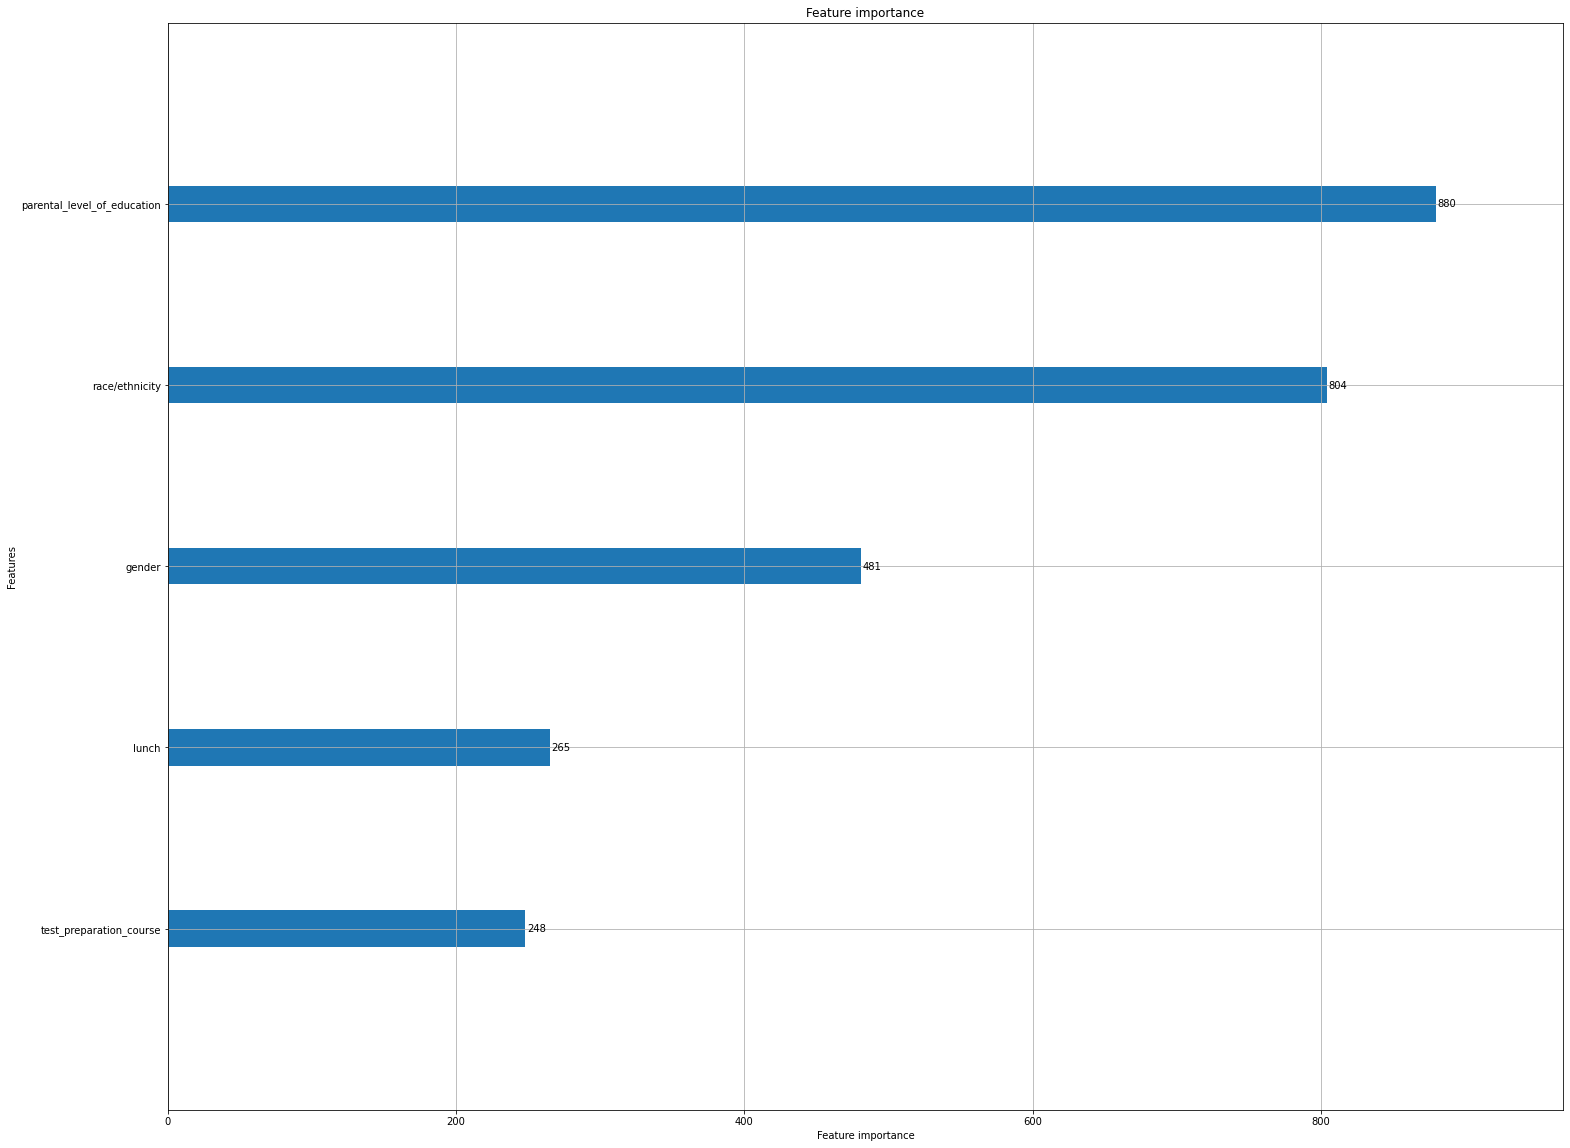

In [75]:
lgb.plot_importance(LGBMReg,figsize=(25,20))

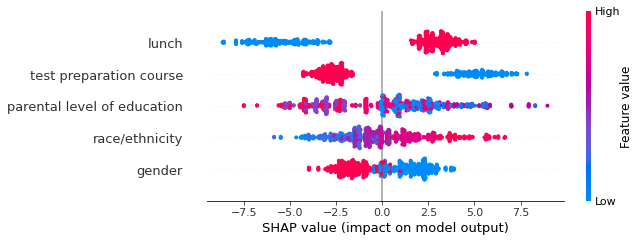

In [79]:
#LGBMReg.params['objective'] = 'regression'
shap_values = shap.TreeExplainer(LGBMReg).shap_values(train_X)
shap.summary_plot(shap_values, train_X)

## CATBoost

In [ ]:
from catboost import CatBoostRegressor
# Initialize data

train_data = train_X

eval_data = valid_X

train_labels = train_y

# Initialize CatBoostRegressor
model = CatBoostRegressor(iterations=2000,
                          learning_rate=1,
                          depth=2)
# Fit model
model.fit(train_data, train_labels)


In [107]:
# Get predictions
pred_train= model.predict(train_data)
pred = model.predict(eval_data)

In [108]:
residual(valid_y, pred)

print("\nScores:")
evaluateRegressor(train_y, pred_train)
evaluateRegressor(valid_y, pred)

12.730170829055233

Scores:
Test set
MSE: 148.9607596040786
MAE: 9.76538646451899
RMSE: 12.204948160646918
R-squared: 0.26570677072859783 , from <0,1> 
Test set
MSE: 162.0572493369288
MAE: 10.280159951339769
RMSE: 12.730170829055233
R-squared: 0.19014976768210012 , from <0,1> 


## ANN

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
# Importing necessary models for implementation of ANN



model = Sequential()
model.add(Dense(100, input_dim=train_X.columns.value_counts().sum(), activation="softmax"))
model.add(Dense(100, activation="relu"))
model.add(Dense(1, kernel_initializer="normal"))
model.compile(loss="mean_squared_error", optimizer = "adam", metrics = ["mse"])

model.fit(train_X, train_y, epochs=300)

TESTIRANJE

In [68]:
from tensorflow.keras.models import Model, load_model
#model.save('cnn_model.h5')
model = load_model('cnn_model.h5')

predicted_valid_y = model.predict(valid_X)
predicted_valid_y = pd.Series([i[0] for i in predicted_valid_y])

In [69]:
residual(valid_y, predicted_valid_y)
evaluateRegressor(valid_y, predicted_valid_y)

15.377039470135166
Test set
MSE: 128.2216772375312
MAE: 9.298129488627117
RMSE: 11.323501103348345
R-squared: 0.3397466131616288 , from <0,1> 


## LOGISTIČKA

## SLUČAJNE SUME

In [16]:
from sklearn.ensemble import RandomForestRegressor

# Creating Random Forest Model
rf = RandomForestRegressor(n_estimators=400)

# Training Model
rf.fit(train_X , train_y)

RandomForestRegressor(n_estimators=400)

In [17]:
# Predictions
predictions = rf.predict(valid_X)

In [18]:
residual(valid_y, predictions)
evaluateRegressor(valid_y, predictions)

14.522529864447256
Test set
MSE: 210.90387366376243
MAE: 11.311023309589608
RMSE: 14.522529864447256
R-squared: 0.00034350192611809494 , from <0,1> 


## SVM

In [ ]:
SVM = svm.SVR().fit(train_X, train_y) 

In [ ]:
predicted_train_y = SVM.predict(train_X)                           #<----SVM -- Support Vector Machine
evaluateRegressor(train_y,predicted_train_y,"    Training Set")
predicted_valid_y = SVM.predict(valid_X)
evaluateRegressor(valid_y,predicted_valid_y,"    Test Set")

In [ ]:
from sklearn.svm import SVR
def SV_reg(kernel,train_X, train_Y):
    model=SVR(kernel)
    model.fit(train_X, train_Y)
    return model


SVM_model= SV_reg("linear",train_X, train_y)
pred_linear = SVM_model.predict(valid_X)
linear_rmse = np.sqrt(mean_squared_error(valid_y,pred_linear))

SVM_model= SV_reg("poly",train_X, train_y)
pred_poly = SVM_model.predict(valid_X)
poly_rmse = np.sqrt(mean_squared_error(valid_y,pred_poly))

SVM_model= SV_reg("sigmoid",train_X, train_y)
pred_sigmoid = SVM_model.predict(valid_X)
sigmoid_rmse = np.sqrt(mean_squared_error(valid_y,pred_sigmoid))

SVM_model= SV_reg("rbf",train_X, train_y)
pred_rbf = SVM_model.predict(valid_X)
rbf_rmse = np.sqrt(mean_squared_error(valid_y,pred_rbf))



data = {"kernel":pd.Series(["linear","polynomial","sigmoid","rbf"]),
            "Test RMSE":pd.Series([linear_rmse,poly_rmse,sigmoid_rmse,rbf_rmse]),
            "Pred":pd.Series([pred_linear,pred_poly,pred_sigmoid,pred_rbf])}
table_rmse=pd.DataFrame(data)
table_rmse

SLJEDECA SE DUGO IZVRSAVA

In [ ]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

K = 15
parameters = [{'kernel': ['linear','sigmoid','rbf'], 'gamma': [2e-3,2e-2, 2e-1, 1, 2, 4, 8, 16],'C': [2e-5,2e-4,2e-3,2e-2, 2e-1, 1, 2, 4, 8, 16]}]
scorer = make_scorer(mean_squared_error, greater_is_better=False)
svr_gs = GridSearchCV(SVR(epsilon = 0.01), parameters, cv = K, scoring=scorer)

svr_gs.fit(train_X, train_y)
print(svr_gs.best_params_)

ONCE WE GET BEST RESULTS , WE ONCE AGAIN TRAIN OUR MODEL
Results:
    
    {'C': 2, 'gamma': 0.002, 'kernel': 'linear'}

In [ ]:
regressor = SVR(**svr_gs.best_params_)
regressor.fit(train_X,train_y)
pred=regressor.predict(valid_X)

error = np.sqrt(mean_squared_error(valid_y,pred))
data = {"kernel":pd.Series(["GS Output"]),"Test RMSE":pd.Series([error]),"Pred":pd.Series([pred])}
table_rmse = table_rmse.append(pd.DataFrame(data))
print(table_rmse)

Final 

In [ ]:
svr_test_rmse = table_rmse["Test RMSE"].min()
print("Test RMSE using SVR is:",svr_test_rmse)

# 4. Rezultati